# 설치 

conda install scikit-optimize catboost xgboost lightgbm statsmodels seaborn matplotlib sklearn skpot

 conda install -c anaconda py-xgboost 로 깔아야함..

In [2]:
import pandas as pd
import numpy as np
import ast # convert string to function
import os

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.linear_model import LinearRegression # 일반 회귀 모델
from sklearn.linear_model import Ridge, Lasso, ElasticNet # norm 규제 회귀 모델
from sklearn.linear_model import ARDRegression, BayesianRidge # 베이지안 회귀
from xgboost import XGBRegressor # decision tree 앙상블 모델, 부스팅
from sklearn.model_selection import cross_val_score # model 검증

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import json

# data load

In [3]:
data = pd.read_csv('./data/colorspace_tras.csv')
data.head()

,Top_RGB_R,Top_RGB_G,Top_RGB_B,Bot_RGB_R,Bot_RGB_G,Bot_RGB_B,Top_YUV_Y,Top_YUV_U,Top_YUV_V,Bot_YUV_Y,...,Bot_LAB_L,Bot_LAB_A,Bot_LAB_B,Top_hls_H,Top_hls_L,Top_hls_S,Bot_hls_H,Bot_hls_L,Bot_hls_S,Thickness
0,11.5760,10.8832,8.1364,30.2140,37.7740,50.4468,10.8832,126.6404,128.6928,37.0204,...,37.9392,128.6176,118.6128,22.0552,10.0796,48.2524,108.7624,40.5660,64.2544,48.266667
1,12.4712,12.6248,11.2136,25.9992,34.8912,43.0424,12.5096,127.3584,127.9616,33.1272,...,33.6496,126.7188,121.4292,23.5584,11.9808,19.2812,104.2764,34.6176,63.2720,47.966667
2,12.7704,12.7176,9.9168,31.3148,35.7876,41.8260,12.5384,126.7120,128.2320,35.1444,...,35.5236,127.6692,123.3704,29.7648,11.5876,36.0004,107.4464,36.5932,36.9364,48.166667
3,11.2308,11.4564,8.8540,24.8812,32.4324,39.4952,11.1748,126.9128,128.0560,31.0332,...,30.6900,126.8772,122.1940,26.6792,10.3208,38.6628,104.4104,32.3344,58.2892,48.600000
4,5.4696,3.2120,1.4352,26.0116,32.5420,38.0564,3.6852,126.9400,129.7764,31.2852,...,30.9328,126.7972,123.3564,30.1924,3.4992,183.6056,104.3064,32.1788,48.6532,59.533333


In [4]:
data_1 = data[["Top_RGB_R", "Top_RGB_G", "Top_RGB_B", "Thickness"]]

data_1.head()

,Top_RGB_R,Top_RGB_G,Top_RGB_B,Thickness
0,11.5760,10.8832,8.1364,48.266667
1,12.4712,12.6248,11.2136,47.966667
2,12.7704,12.7176,9.9168,48.166667
3,11.2308,11.4564,8.8540,48.600000
4,5.4696,3.2120,1.4352,59.533333


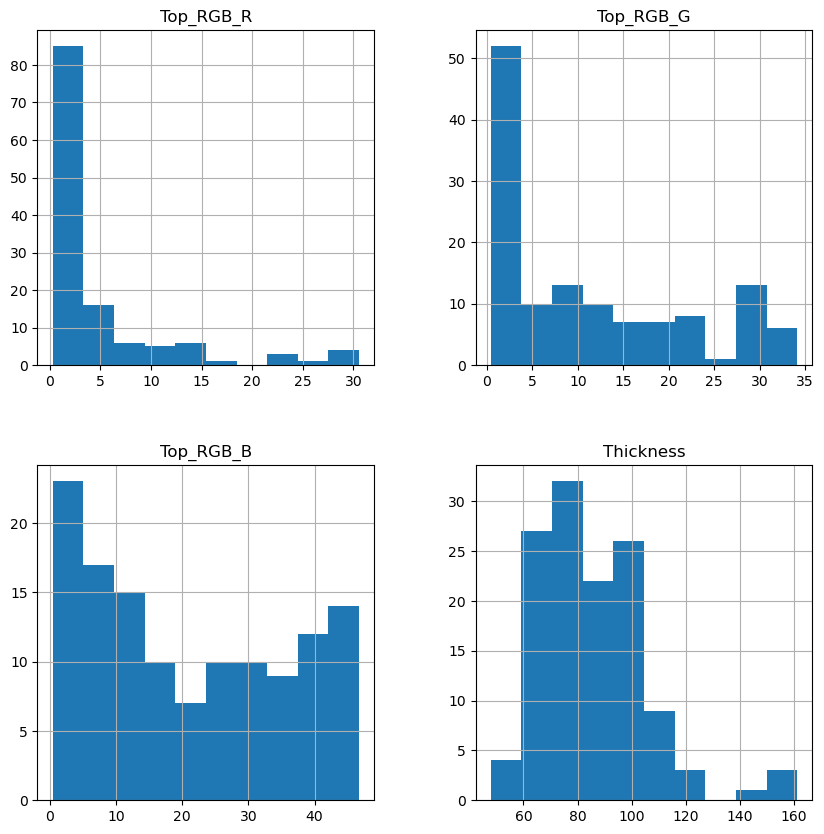

In [5]:
# 데이터 분포 확인 시각화
data_1.hist(figsize=(10, 10))
plt.show()

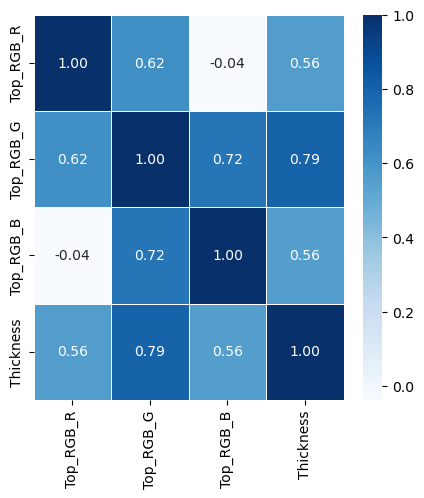

In [6]:
# 상관관계 분석 및 시각화
plt.figure(figsize=(5,5))
sns.heatmap(data=data_1.corr(), annot=True, 
            fmt = '.2f', linewidths=.5, cmap='Blues')
plt.show()


# pipeline 만들기

## 사용한 모델

        'linear': LinearRegression(),
        'ridge': Ridge(), #
        'lasso': Lasso(), #
        'elasticnet': ElasticNet(), #
        'ardr_linear': ARDRegression(),
        'baysian_ridge': BayesianRidge(),
        'random_forest': RandomForestRegressor(), #
        'xgboost_linear': XGBRegressor(), #
        'AdaBoost_linear': AdaBoostRegressor() #

GBM모델 : adaboost, catboost, xgboost, lightgbm<br>
iterations, learning_rate, depth에 대한 하이퍼파라미터를 베이지안서치를 통해 찾습니다.

**추후 추가하기...**



cv : 상세 조정한 kfold 객체


n_jobs : 병렬로 실행할 작업 수 (-1은 전부)


make_scorer의 custom_scoring : custom scoring 함수


make_scorer의 greater_is_better : False는 score 값이 낮은게 좋음을 의미

neg_mean_squared_error는 scikit-learn의 scoring metric으로, 이 메트릭은 Mean Squared Error (MSE)의 반대값(negative)를 계산합니다. scikit-learn은 최적화 문제를 최대화 문제로 항상 고려하기 때문에, "작을수록 좋은" 오차 메트릭을 "클수록 좋은" 스코어로 변환하기 위해 반대값을 사용합니다.

**따라서 scoring 매개변수를 neg_mean_squared_error를 사용하거나 make_scorer의 greater_is_better=False를 이용해서 "작을수록 좋은" 오차메트릭으로 인식하게 해야합니다.**

RGB 피쳐들로 해봅니다.

현재는 데이터가 적으므로 8:2로 train, test를 나눕니다.



In [7]:
# 선택된 피처를 사용하여 데이터를 나눕니다.
X = data[['Top_RGB_R','Top_RGB_G', 'Top_RGB_B',]]
y = data['Thickness']

# 훈련과 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# RMSE 스코어링 함수
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False) # greater_is_better=False 옵션으로 인해 스코어가 음수로 반환

In [34]:
def my_regressor(df_X, df_y):
    # Define models
    models = {
        'linear': LinearRegression(),
        'ridge': Ridge(), #
        'lasso': Lasso(), #
        'elasticnet': ElasticNet(), #
        'ardr_linear': ARDRegression(),
        'baysian_ridge': BayesianRidge(),
        'random_forest': RandomForestRegressor(), #
        'xgboost_linear': XGBRegressor(), #
        'AdaBoost_linear': AdaBoostRegressor() #
    }

    score_dic = dict()
    for model_nm, model in models.items():
        print(f"{model_nm} training")
        params = model.get_params()
        scores = cross_val_score(model, df_X, df_y, cv=5, n_jobs=-1, scoring=rmse_scorer)

        rmse_score = -scores.mean() #kfold로 인해 5개의 평가에 대한 점수의 평균을 냄
        score_dic[model_nm] = {
            'score': rmse_score,
            'params': model.get_params()
        }

    score_dic = sorted(score_dic.items(), key=lambda t : t[1]['score'])

    return score_dic

In [52]:
linear_model_train_score = my_regressor(X_train, y_train)
print(linear_model_train_score)
#print(type(linear_model_train_score))

import json
with open("./save_model_weight/model_scores.json", "w") as f:
    for model_score in linear_model_train_score:
        f.write(json.dumps({
            "model": model_score[0],
            "score": model_score[1]["score"],
            "params": model_score[1]["params"]
        }) + "\n")
print("Model scores saved to model_scores.json")

linear training
ridge training
lasso training
elasticnet training
ardr_linear training
baysian_ridge training
random_forest training
xgboost_linear training
AdaBoost_linear training
[('AdaBoost_linear', {'score': 4.88436161292395, 'params': {'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 50, 'random_state': None}}), ('random_forest', {'score': 6.669394530644719, 'params': {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}}), ('xgboost_linear', {'score': 8.666066284037974, 'params': {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample

In [53]:
model_number = 0

In [54]:
linear_model_train_score = my_regressor(X_train, y_train)

import json
with open(f"./save_model_weight/model_scores{model_number}.json", "w") as f:
    for model_score in linear_model_train_score:
        f.write(json.dumps({
            "model": model_score[0],
            "score": model_score[1]["score"],
            "params": model_score[1]["params"]
        }) + "\n")
model_number += 1        
print(f"Model scores saved to model_scores.json")

linear training
ridge training
lasso training
elasticnet training
ardr_linear training
baysian_ridge training
random_forest training
xgboost_linear training
AdaBoost_linear training
Model scores saved to model_scores.json


randomseed 42일때

In [26]:
linear_model_train_score = my_regressor(X_train, y_train)
print(linear_model_train_score)

linear
ridge
lasso
elasticnet
ardr_linear
baysian_ridge
random_forest
xgboost_linear
AdaBoost_linear
[('AdaBoost_linear', 5.575739826648291), ('random_forest', 6.377262698383353), ('xgboost_linear', 8.666066284037974), ('baysian_ridge', 12.296467823054677), ('elasticnet', 12.393186829641387), ('lasso', 12.429173949366382), ('ridge', 12.432605940351351), ('linear', 12.433722421177388), ('ardr_linear', 12.553462995807937)]


In [64]:
def my_regressor(df_X, df_y, X_test):
    # Define models
    models = {
        'linear': LinearRegression(),
        'ridge': Ridge(), #
        'lasso': Lasso(), #
        'elasticnet': ElasticNet(), #
        'ardr_linear': ARDRegression(),
        'baysian_ridge': BayesianRidge(),
        'random_forest': RandomForestRegressor(), #
        'xgboost_linear': XGBRegressor(), #
        'AdaBoost_linear': AdaBoostRegressor() #
    }

    score_dic = dict()
    predictions_dic = dict()

    for model_nm, model in models.items():
        print(f"{model_nm} training")
        params = model.get_params()
        scores = cross_val_score(model, df_X, df_y, cv=5, n_jobs=-1, scoring=rmse_scorer)

        rmse_score = -scores.mean() #kfold로 인해 5개의 평가에 대한 점수의 평균을 냄
        
        score_dic[model_nm] = {
            'score': rmse_score,
            'params': model.get_params()
        }
        
        model.fit(df_X, df_y)
        predictions = model.predict(X_test)
        predictions_dic[model_nm] = predictions

    #score_dic = sorted(score_dic.items(), key=lambda x : x[1]['score'])

    return score_dic, predictions_dic

1

linear training
ridge training
lasso training
elasticnet training
ardr_linear training
baysian_ridge training
random_forest training
xgboost_linear training
AdaBoost_linear training
1


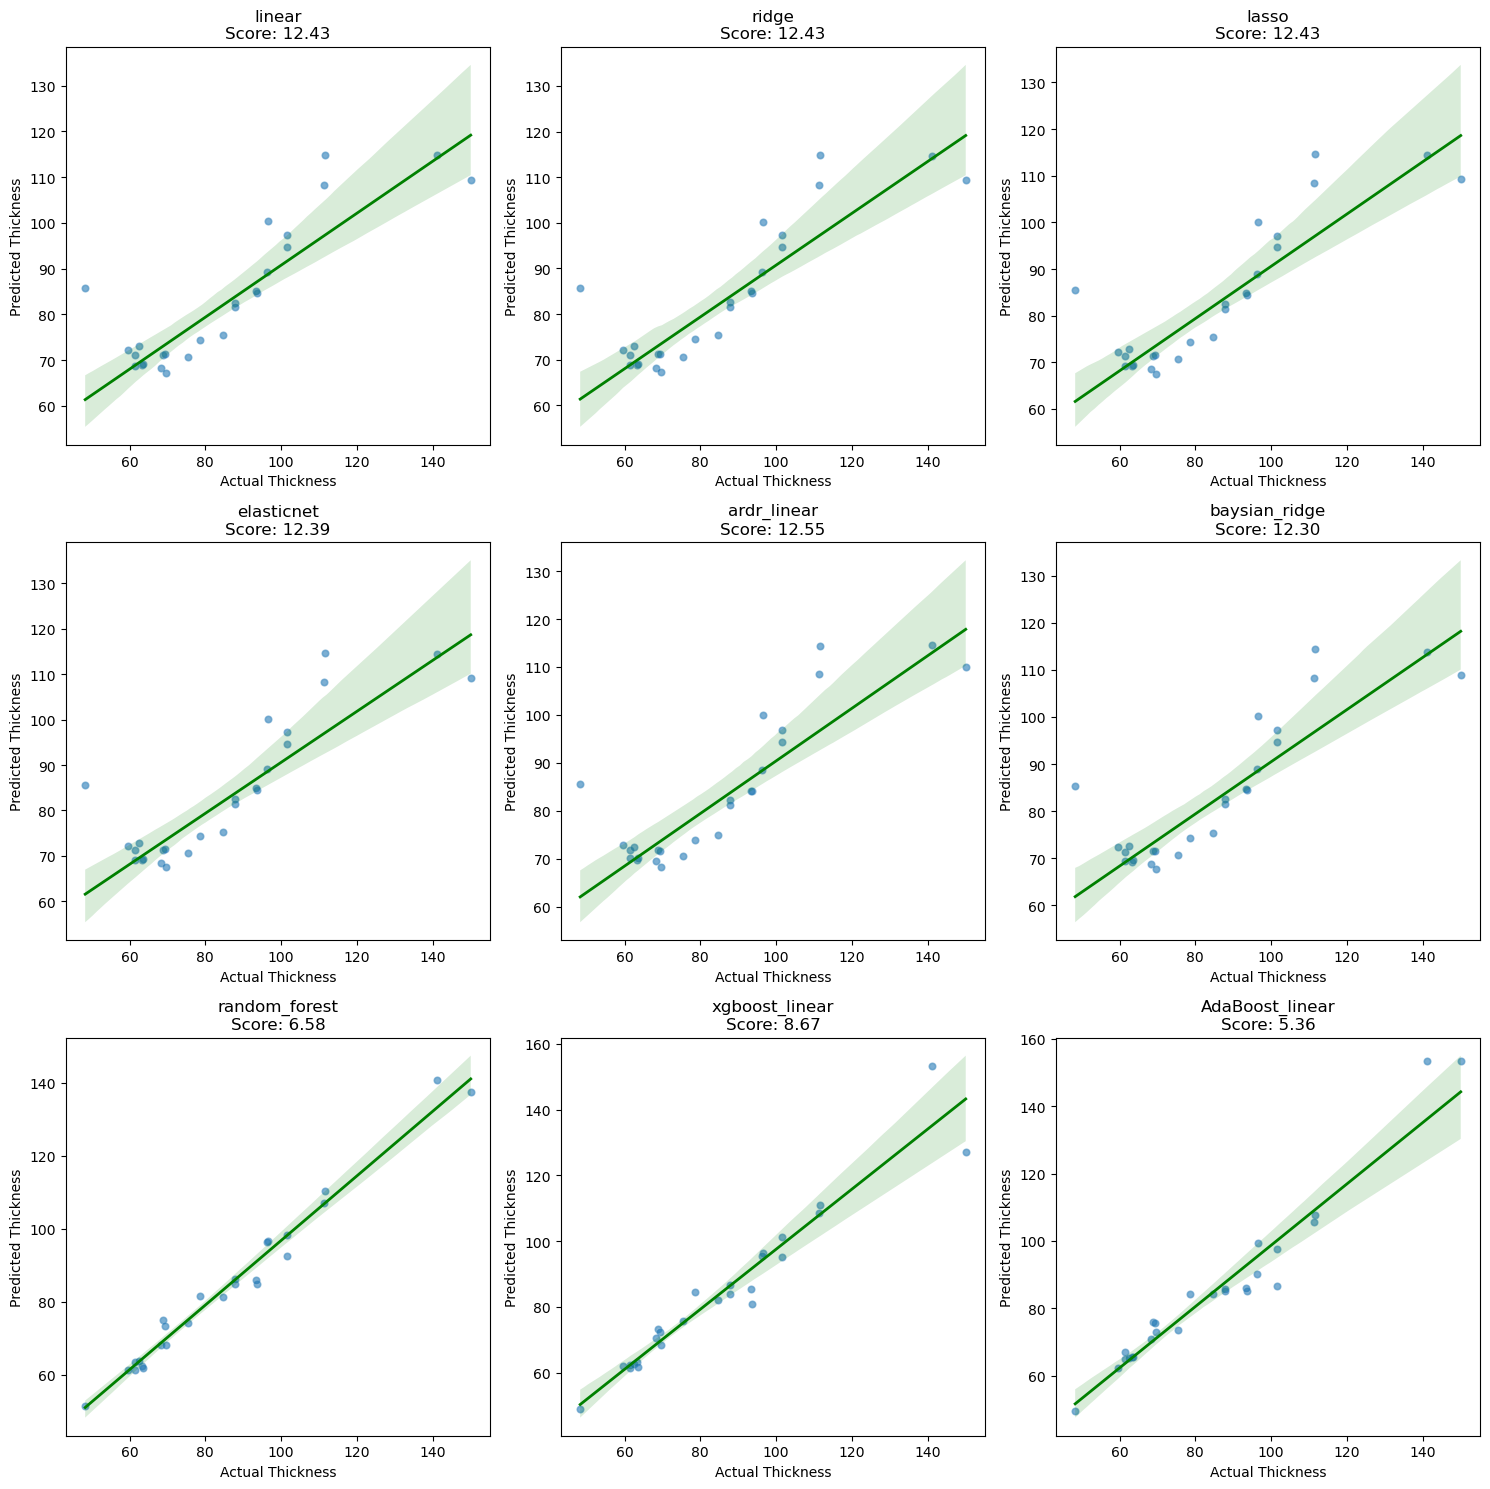

In [73]:
model_scores, predictions = my_regressor(X_train, y_train, X_test)
print(model_scores)
#print(predictions)

model_scores_sorted = sorted(model_scores.items(), key=lambda x: x[1]['score'])

print(f'saved name model_scores{model_number}.json')
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.ravel()

for i, (model_name, preds) in enumerate(predictions.items()):
    score = [model[1]['score'] for model in model_scores_sorted if model[0] == model_name][0]
    sns.scatterplot(x=y_test, y=preds, alpha=0.4, ax=axs[i])
    sns.regplot(x=y_test, y=preds, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, robust=True, ax=axs[i])
    axs[i].set_xlabel('Actual Thickness')
    axs[i].set_ylabel('Predicted Thickness')
    axs[i].set_title(f'{model_name}\nScore: {score:.2f}')

plt.tight_layout()
plt.show()

In [74]:
with open(f"./save_model_weight/model_scores{model_number}.json", "w") as f:
    for model_score in model_scores_sorted:
        f.write(json.dumps({
            "model": model_score[0],
            "score": model_score[1]["score"],
            "params": model_score[1]["params"]
        }) + "\n")
model_number += 1        
print(f"Model scores saved to model_scores.json")

Model scores saved to model_scores.json


2

linear training
ridge training
lasso training
elasticnet training
ardr_linear training
baysian_ridge training
random_forest training
xgboost_linear training
AdaBoost_linear training
{'linear': {'score': 12.433722421177388, 'params': {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}}, 'ridge': {'score': 12.432605940351351, 'params': {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}}, 'lasso': {'score': 12.429173949366382, 'params': {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}}, 'elasticnet': {'score': 12.393186829641387, 'params': {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_

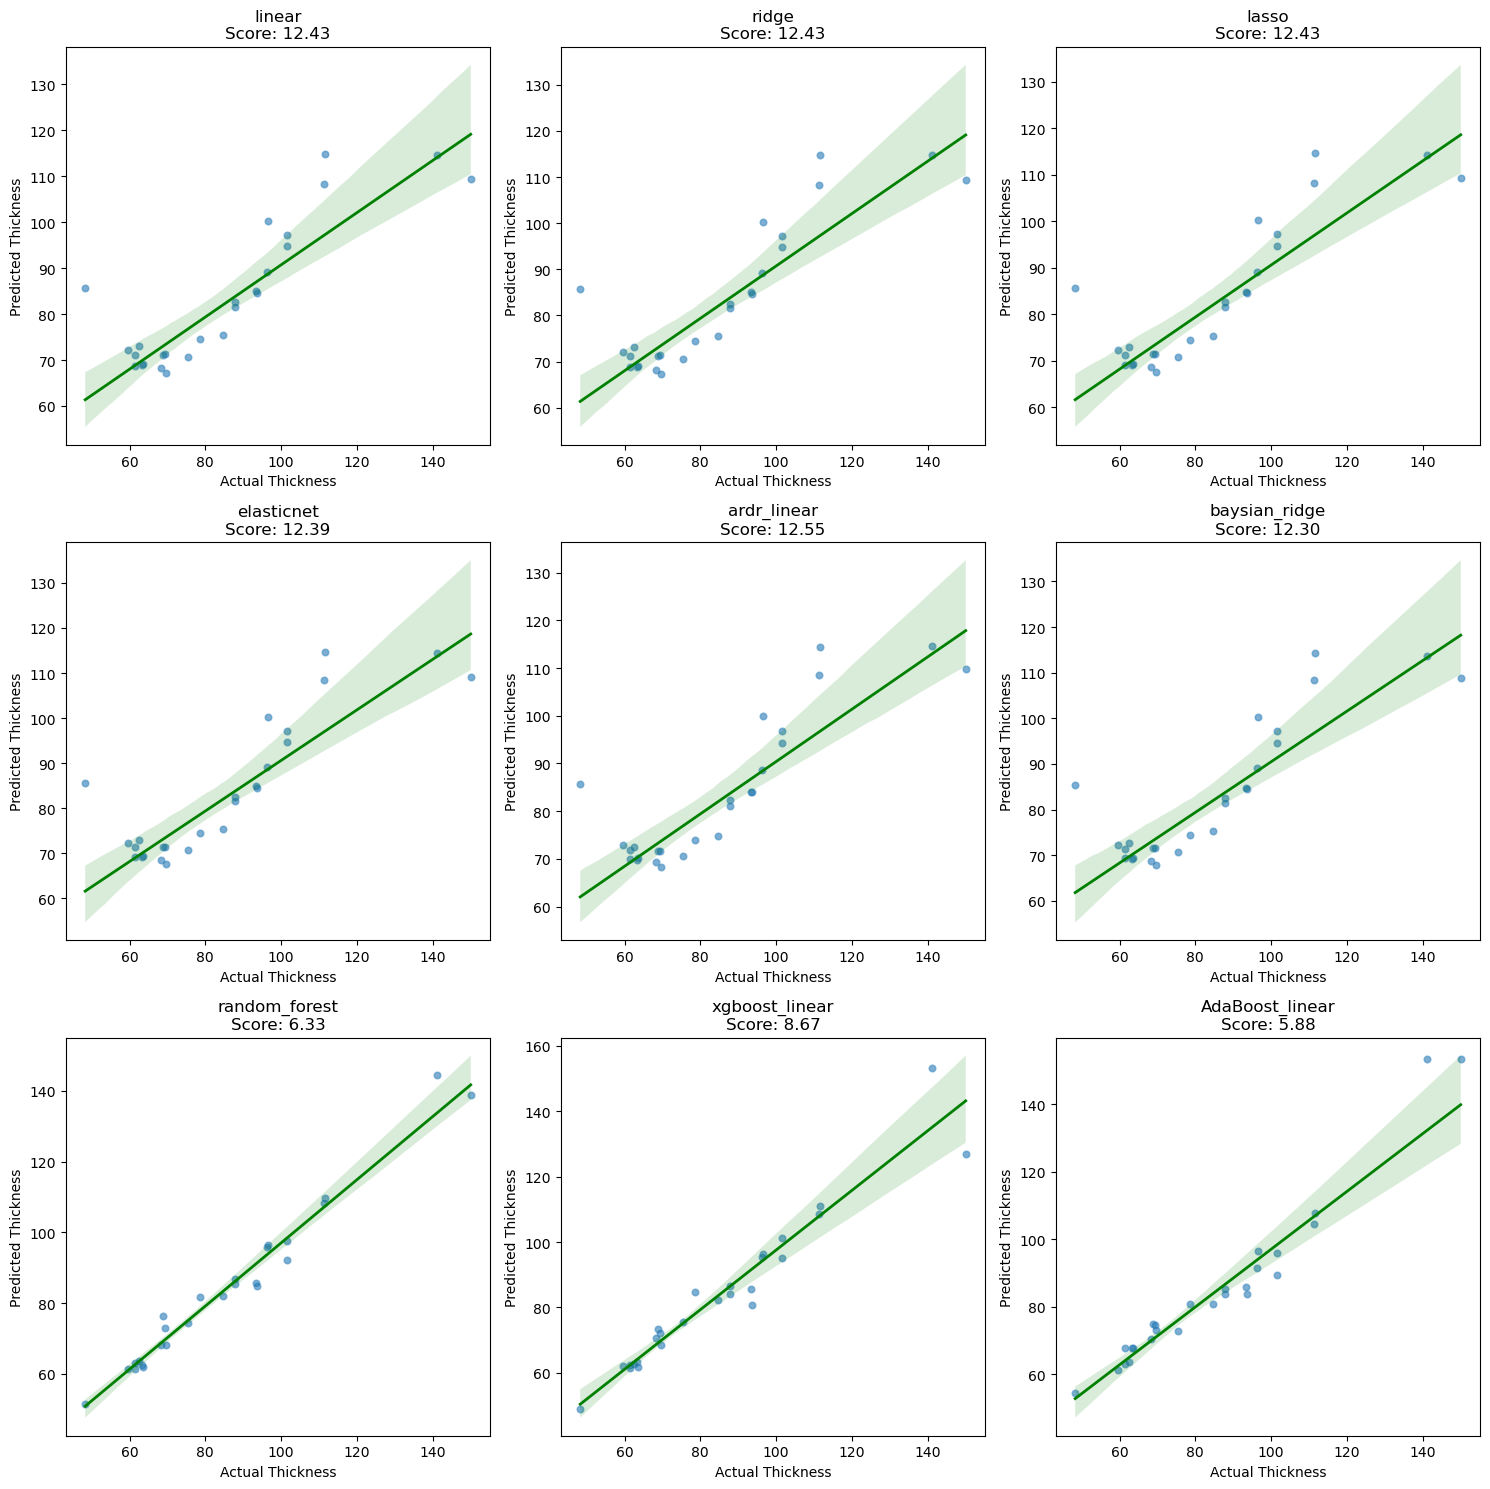

In [75]:
model_scores, predictions = my_regressor(X_train, y_train, X_test)
print(model_scores)
#print(predictions)

model_scores_sorted = sorted(model_scores.items(), key=lambda x: x[1]['score'])

print(f'saved name model_scores{model_number}.json')
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.ravel()

for i, (model_name, preds) in enumerate(predictions.items()):
    score = [model[1]['score'] for model in model_scores_sorted if model[0] == model_name][0]
    sns.scatterplot(x=y_test, y=preds, alpha=0.4, ax=axs[i])
    sns.regplot(x=y_test, y=preds, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, robust=True, ax=axs[i])
    axs[i].set_xlabel('Actual Thickness')
    axs[i].set_ylabel('Predicted Thickness')
    axs[i].set_title(f'{model_name}\nScore: {score:.2f}')

plt.tight_layout()
plt.show()

In [76]:
with open(f"./save_model_weight/model_scores{model_number}.json", "w") as f:
    for model_score in model_scores_sorted:
        f.write(json.dumps({
            "model": model_score[0],
            "score": model_score[1]["score"],
            "params": model_score[1]["params"]
        }) + "\n")
model_number += 1        
print(f"Model scores saved to model_scores{model_number}.json")

Model scores saved to model_scores.json
